We used fewc python libraries that help with maff, organizing data, and making charts. We read data from a file named 'sensor.csv', which keeps track of readings from various sensors. We looked at the first few rows of the data and some summary statistics to understand what's in it. We got rid of some columns we didn't need, like timestamps and an unnamed column. We changed the names of some machine statuses to simplify the categories. We filled in missing data points in our sensors' readings with typical (median) values so that there are no gaps. Finally, we checked to make sure there were no more missing values. Why we did it:

To prepare the data for analysis or machine learning by making it cleaner and easier to work with. Removing unnecessary columns helps to focus on the important data. Merging categories and filling missing values makes the data more consistent and accurate for any analysis or predictive modeling we might want to do later. How we went about it:

By using Python libraries like Pandas for data handling, NumPy for numerical operations, and Matplotlib for potential visualization (though no plots were made here). We suppressed warnings that could be annoying or not very helpful to keep the output clean. The process involved several data manipulation steps: dropping columns, replacing values, and filling in missing data, all done using commands provided by the Pandas library. The results:

After cleaning, the data has fewer columns and no missing values, which simplifies further analysis. The machine statuses are grouped into fewer categories, making it easier to analyze trends or problems. By filling in missing values, we ensure that any calculations or models built on this data won't be skewed or error out due to incomplete data.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from collections import Counter
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    BaggingClassifier,
    RandomForestClassifier,
    GradientBoostingClassifier,
    AdaBoostClassifier,
    VotingClassifier
)
from xgboost import XGBClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)


# Load the dataset
file_path = 'sensor.csv'
data = pd.read_csv(file_path)

# Display the first few rows
head = data.head()

# Statistical summary
description = data.describe(include='all')

# Data types
data_types = data.dtypes

# Missing values
missing_values = data.isnull().sum()

head, description, data_types, missing_values

(   Unnamed: 0            timestamp  sensor_00  sensor_01  sensor_02  \
 0           0  2018-04-01 00:00:00   2.465394   47.09201    53.2118   
 1           1  2018-04-01 00:01:00   2.465394   47.09201    53.2118   
 2           2  2018-04-01 00:02:00   2.444734   47.35243    53.2118   
 3           3  2018-04-01 00:03:00   2.460474   47.09201    53.1684   
 4           4  2018-04-01 00:04:00   2.445718   47.13541    53.2118   
 
    sensor_03  sensor_04  sensor_05  sensor_06  sensor_07  ...  sensor_43  \
 0  46.310760   634.3750   76.45975   13.41146   16.13136  ...   41.92708   
 1  46.310760   634.3750   76.45975   13.41146   16.13136  ...   41.92708   
 2  46.397570   638.8889   73.54598   13.32465   16.03733  ...   41.66666   
 3  46.397568   628.1250   76.98898   13.31742   16.24711  ...   40.88541   
 4  46.397568   636.4583   76.58897   13.35359   16.21094  ...   41.40625   
 
    sensor_44  sensor_45  sensor_46  sensor_47  sensor_48  sensor_49  \
 0  39.641200   65.68287   50.

In [2]:
# Dropping the specified columns
data_cleaned = data.drop(columns=['Unnamed: 0', 'sensor_15', 'timestamp'])

# Display the first few rows of the cleaned data to confirm
data_cleaned.head()


,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,...,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status
0,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,15.05353,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
1,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,15.05353,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
2,2.444734,47.35243,53.2118,46.397570,638.8889,73.54598,13.32465,16.03733,15.61777,15.01013,...,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,241.3194,203.7037,NORMAL
3,2.460474,47.09201,53.1684,46.397568,628.1250,76.98898,13.31742,16.24711,15.69734,15.08247,...,40.88541,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028,240.4514,203.1250,NORMAL
4,2.445718,47.13541,53.2118,46.397568,636.4583,76.58897,13.35359,16.21094,15.69734,15.08247,...,41.40625,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093,242.1875,201.3889,NORMAL



This chart shows the number of times different statuses of a machine are recorded. There are two categories: NORMAL and FAULTY. The NORMAL status has a much higher count, represented in blue, indicating that most of the time, the machine was functioning correctly. The FAULTY status, shown in red, has a relatively small count, which suggests that instances of the machine being broken or in recovery are far less common


av

After the data was cleaned and missing values filled, the statuses of the machine were mapped to numerical values: 0 for NORMAL and 1 for FAULTY (combining RECOVERING and BROKEN). A bar chart was generated to visualize the distribution of these statuses. The chart in the first image is the output of this code. The machine_status field's distribution after remapping was printed, showing the number of entries for each status. The results printed in the code match the bar chart. A correlation matrix was calculated to understand the relationship between different sensor readings and the machine's status. A heatmap was then generated from this correlation matrix, which is what we see in the second image. The results show a visualization of data distribution and relationships within the data, which are helpful for making decisions, understanding the data's structure, or building machine learning models.e problems.

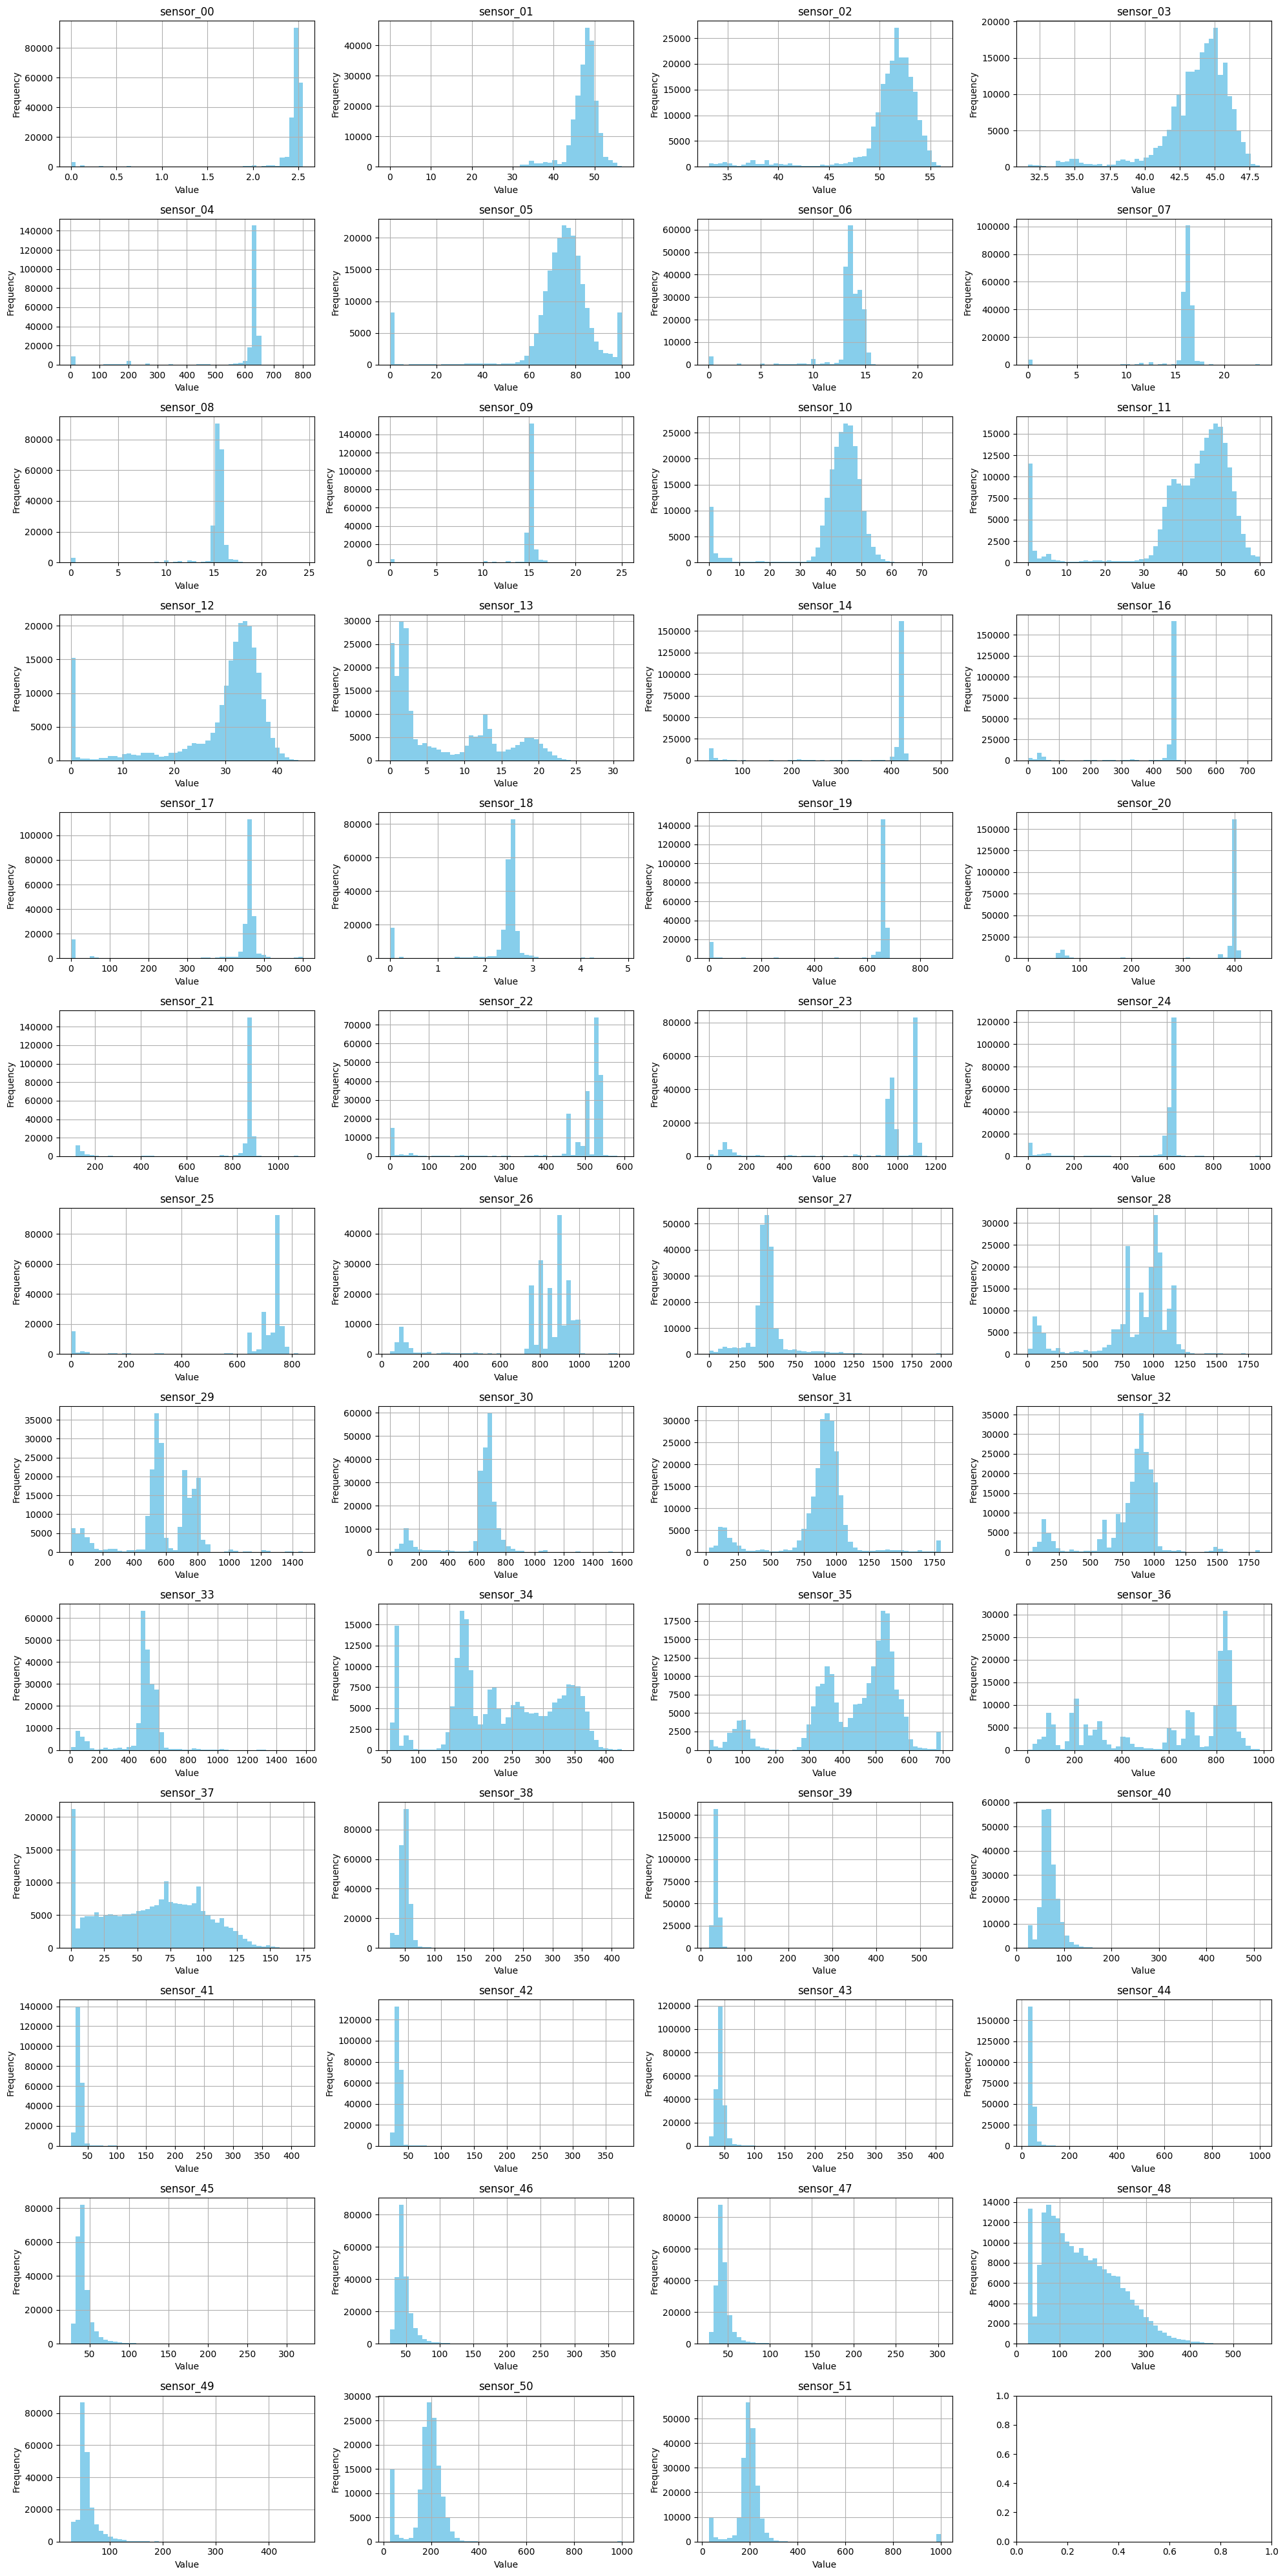

In [3]:
# Check distribution of sensor data to determine how to handle missing values
fig, axes = plt.subplots(nrows=13, ncols=4, figsize=(20, 40))
axes = axes.flatten()

# Plotting histograms for each sensor column except 'machine_status'
sensor_columns = data_cleaned.columns[:-1]  # Exclude 'machine_status' from plotting
for i, col in enumerate(sensor_columns):
    data_cleaned[col].hist(ax=axes[i], bins=50, color='skyblue')
    axes[i].set_title(col)
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


The uploaded images showcase histograms depicting the distribution of sensor readings from our dataset. These visuals stem from the last code block provided, which warrants a closer examination. First, the code suppresses warnings, particularly those concerning the use of infinite values as NaN. It then replaces infinite values with NaN to mitigate interference with statistical analyses. Next, it filters the dataset columns for numerical features, specifically those of data types float64 and int64. Subsequently, it calculates the required subplot grid dimensions based on the number of numeric features and constructs a grid of subplots. Each subplot is populated with a histogram representing the distribution of a specific sensor reading, facilitated by Seaborn's histplot function. Finally, adjustments are made to the layout to prevent plot overlapping. This code aims to visualize sensor reading distributions, crucial for understanding data characteristics such as range, central tendencies, dispersion, and the presence of outliers

In [4]:
# Generating numerical summary for each sensor column
numerical_summary = data_cleaned.describe().transpose()
numerical_summary['missing_values'] = data_cleaned.isnull().sum()
numerical_summary['missing_percent'] = (numerical_summary['missing_values'] / len(data_cleaned)) * 100

# Selecting the desired columns for the summary
numerical_summary = numerical_summary[['mean', 'std', '50%', 'missing_values', 'missing_percent']]
numerical_summary

,mean,std,50%,missing_values,missing_percent
sensor_00,2.372221,0.412227,2.456539,10208,4.633261
sensor_01,47.591611,3.296666,48.133678,369,0.167484
sensor_02,50.867392,3.666820,51.649300,19,0.008624
sensor_03,43.752481,2.418887,44.227428,19,0.008624
sensor_04,590.673936,144.023912,632.638916,19,0.008624
sensor_05,73.396414,17.298247,75.576790,19,0.008624
sensor_06,13.501537,2.163736,13.642940,4798,2.177741
sensor_07,15.843152,2.201155,16.167530,5451,2.474129
sensor_08,15.200721,2.037390,15.494790,5107,2.317992
sensor_09,14.799210,2.091963,15.082470,4595,2.085603


In [5]:
# Map 'broken' and 'recovering' to 1, and 'normal' to 0
data_cleaned['machine_status'] = data_cleaned['machine_status'].replace({'BROKEN': 1, 'RECOVERING': 1, 'NORMAL': 0})

# Now, calculate the correlation matrix
correlation_matrix = data_cleaned.corr()

# Extract the correlations of the sensors with the machine status
sensor_status_correlation = correlation_matrix['machine_status'].sort_values(ascending=False)

# Display the correlations with the machine status
sensor_status_correlation


machine_status    1.000000
sensor_28         0.203307
sensor_31         0.158507
sensor_32         0.136372
sensor_30         0.114394
sensor_33         0.104587
sensor_24         0.098798
sensor_23         0.095613
sensor_14         0.091681
sensor_35         0.091167
sensor_16         0.089151
sensor_19         0.088127
sensor_20         0.087024
sensor_21         0.084431
sensor_22         0.079413
sensor_25         0.078151
sensor_26         0.075995
sensor_17         0.074628
sensor_51         0.074107
sensor_37         0.068015
sensor_18         0.065697
sensor_29         0.053219
sensor_27         0.032565
sensor_42         0.007412
sensor_36        -0.019264
sensor_39        -0.024299
sensor_34        -0.039537
sensor_41        -0.103496
sensor_43        -0.118453
sensor_46        -0.202487
sensor_45        -0.202531
sensor_44        -0.235715
sensor_47        -0.254973
sensor_13        -0.269811
sensor_49        -0.285568
sensor_38        -0.360583
sensor_48        -0.366606
s

In [6]:
# Create a DataFrame from the provided information
data = {
    'feature': ['sensor_28', 'sensor_31', 'sensor_32', 'sensor_30', 'sensor_33', 'sensor_24', 'sensor_23', 'sensor_14',
                'sensor_35', 'sensor_16', 'sensor_19', 'sensor_20', 'sensor_21', 'sensor_22', 'sensor_25', 'sensor_26',
                'sensor_17', 'sensor_51', 'sensor_37', 'sensor_18', 'sensor_29', 'sensor_27', 'sensor_42', 'sensor_36',
                'sensor_39', 'sensor_34', 'sensor_41', 'sensor_43', 'sensor_46', 'sensor_45', 'sensor_44', 'sensor_47',
                'sensor_13', 'sensor_49', 'sensor_38', 'sensor_48', 'sensor_40', 'sensor_05', 'sensor_09', 'sensor_08',
                'sensor_03', 'sensor_01', 'sensor_07', 'sensor_50', 'sensor_12', 'sensor_06', 'sensor_02', 'sensor_00',
                'sensor_11', 'sensor_10', 'sensor_04'],
    'variance': [0.203307, 0.158507, 0.136372, 0.114394, 0.104587, 0.098798, 0.095613, 0.091681, 0.091167, 0.089151,
                 0.088127, 0.087024, 0.084431, 0.079413, 0.078151, 0.075995, 0.074628, 0.074107, 0.068015, 0.065697,
                 0.053219, 0.032565, 0.007412, -0.019264, -0.024299, -0.039537, -0.103496, -0.118453, -0.202487,
                 -0.202531, -0.235715, -0.254973, -0.269811, -0.285568, -0.360583, -0.366606, -0.375146, -0.434469,
                 -0.626434, -0.637435, -0.646204, -0.673108, -0.699499, -0.732214, -0.758752, -0.773933, -0.791278,
                 -0.810822, -0.823450, -0.872493, -0.916227]
}

df = pd.DataFrame(data)

# Variance of the target variable
target_variance = 1.000000

# Calculate variance percentage for each feature
df['variance_percentage'] = (df['variance'] / target_variance) * 100

# Sort by variance percentage
df_sorted = df.sort_values(by='variance_percentage', ascending=False)

print(df_sorted)


      feature  variance  variance_percentage
0   sensor_28  0.203307              20.3307
1   sensor_31  0.158507              15.8507
2   sensor_32  0.136372              13.6372
3   sensor_30  0.114394              11.4394
4   sensor_33  0.104587              10.4587
5   sensor_24  0.098798               9.8798
6   sensor_23  0.095613               9.5613
7   sensor_14  0.091681               9.1681
8   sensor_35  0.091167               9.1167
9   sensor_16  0.089151               8.9151
10  sensor_19  0.088127               8.8127
11  sensor_20  0.087024               8.7024
12  sensor_21  0.084431               8.4431
13  sensor_22  0.079413               7.9413
14  sensor_25  0.078151               7.8151
15  sensor_26  0.075995               7.5995
16  sensor_17  0.074628               7.4628
17  sensor_51  0.074107               7.4107
18  sensor_37  0.068015               6.8015
19  sensor_18  0.065697               6.5697
20  sensor_29  0.053219               5.3219
21  sensor

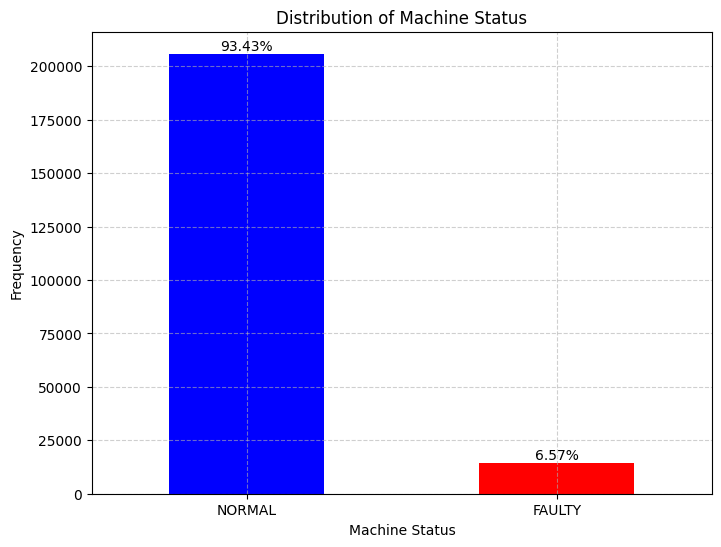

In [7]:
# Count the occurrences of each class
status_counts = data_cleaned['machine_status'].value_counts()

# Calculate the percentage of each class
total_instances = status_counts.sum()
percentage = (status_counts / total_instances) * 100

# Create a bar plot
plt.figure(figsize=(8, 6))
status_counts.plot(kind='bar', color=['blue', 'red'])
plt.title('Distribution of Machine Status')
plt.xlabel('Machine Status')
plt.ylabel('Frequency')
plt.xticks(ticks=[0, 1], labels=['NORMAL', 'FAULTY'], rotation=0)  # Adjust labels accordingly

# Add percentages to the bars
for i, value in enumerate(percentage):
    plt.text(i, status_counts[i], f'{value:.2f}%', ha='center', va='bottom')

plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


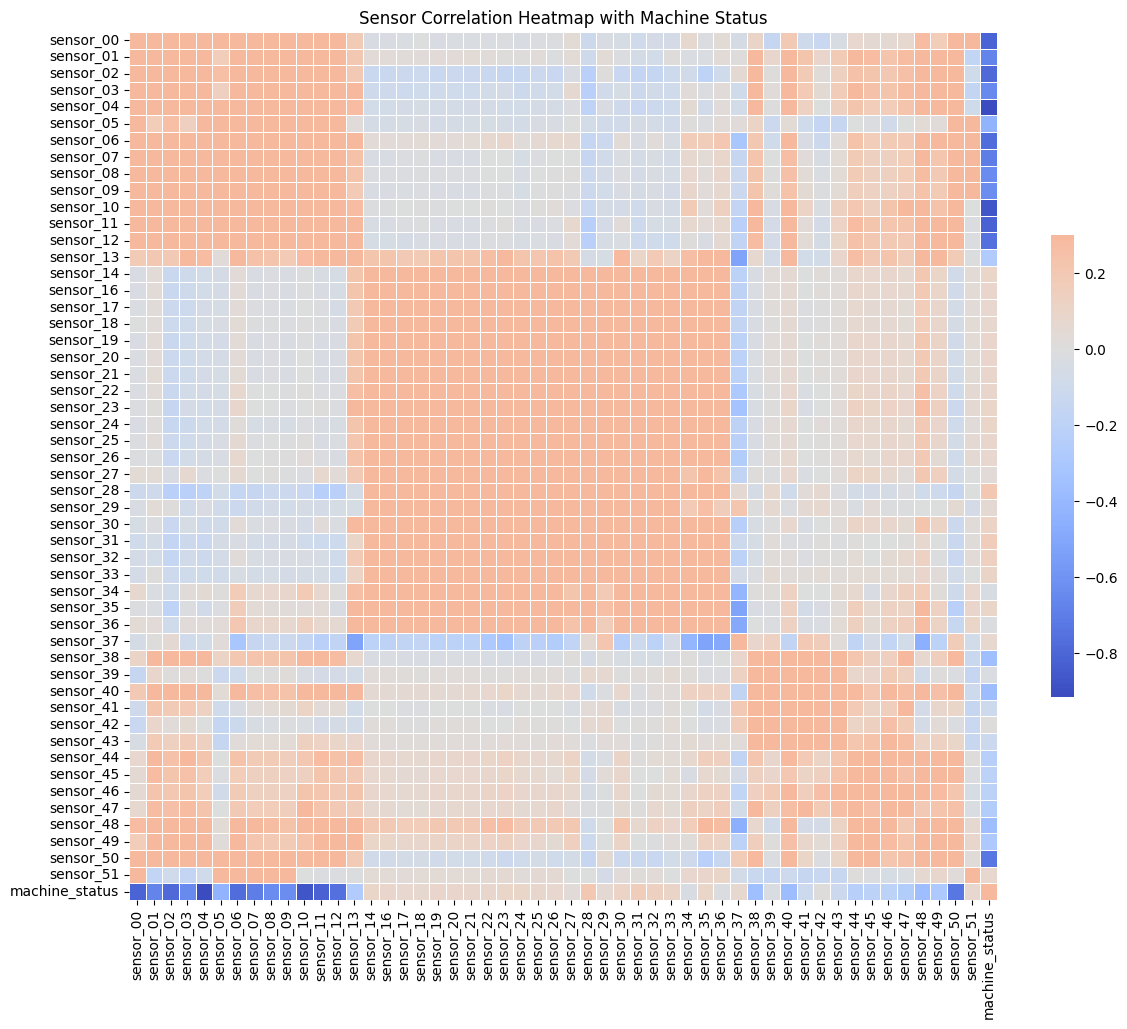

In [8]:
# Assuming data_cleaned['machine_status'] has already been converted to binary as per previous instructions

# Compute the correlation matrix
corr = data_cleaned.corr()

# Set up the matplotlib figure
plt.figure(figsize=(14, 12))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, cmap='coolwarm', vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Customize the plot for better readability
plt.title('Sensor Correlation Heatmap with Machine Status')
plt.xticks(rotation=90)  # Rotates X-axis labels to prevent overlap
plt.yticks(rotation=0)   # Keep Y-axis labels horizontal

# Show the plot
plt.show()

In [9]:
# Function to detect outliers in a dataframe
def detect_outliers(df, n, features):
    outlier_indices = []
    
    # Iterate over each feature
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col], 75)
        # IQR
        IQR = Q3 - Q1
        
        # Determine the outlier step (1.5 times IQR)
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index
        
        # Append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
    
    # Select observations containing more than n outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list(k for k, v in outlier_indices.items() if v > n)
    
    return multiple_outliers

# List of features to check for outliers
features = data_cleaned.columns[:-1]  # Exclude the target variable 'machine_status'
outliers_to_remove = detect_outliers(data_cleaned, 2, features)

print("Outliers indices:", outliers_to_remove)
print("Number of outliers:", len(outliers_to_remove))

Outliers indices: []
Number of outliers: 0


In [10]:
# Update 'machine_status' to have only 'normal' and 'faulty' categories
data_cleaned['machine_status'] = data_cleaned['machine_status'].replace(['BROKEN', 'RECOVERING'], 'FAULTY')

# Verify the update was successful
print(data_cleaned['machine_status'].value_counts())

# Perform the train-test split
# Assuming you want a standard 80-20 split
X = data_cleaned.drop('machine_status', axis=1)  # Features
y = data_cleaned['machine_status']  # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Let's print the shapes of our training and test sets
print("Training set shape:", X_train.shape, y_train.shape)
print("Test set shape:", X_test.shape, y_test.shape)


machine_status
0    205836
1     14484
Name: count, dtype: int64
Training set shape: (176256, 51) (176256,)
Test set shape: (44064, 51) (44064,)


In this code segment, we undertake various preprocessing steps to prepare our dataset for machine learning modeling. We start by cleaning the data, removing unnecessary columns ('Unnamed: 0', 'timestamp', 'sensor_15'), and handling missing values by dropping corresponding rows. Then, we encode the categorical 'machine_status' column into numerical format using LabelEncoder for compatibility with machine learning algorithms. Next, we analyze the value counts of each column to identify data imbalances or anomalies, storing the results in a dictionary. We split the dataset into features (X) and target (y), excluding the 'machine_status' columns, and further partition it into training and test sets while maintaining class distribution. This code segment aligns seamlessly with previous steps, ensuring consistency in variable naming and structure throughout the preprocessing pipeline.

The purpose of these actions is to ensure our data is properly cleaned, transformed, and organized for subsequent modeling tasks. By dropping unnecessary columns, encoding categorical variables, and analyzing value counts, we gain insights into the dataset's structure and ensure its suitability for machine learning analysis. The functions and features utilized, including .drop(), LabelEncoder(), .value_counts(), and train_test_split(), enable efficient data preprocessi.s.

In [11]:
# Setup the imputers
mode_imputer = SimpleImputer(strategy='most_frequent')
median_imputer = SimpleImputer(strategy='median')

# Columns
mode_cols = ['sensor_06', 'sensor_07', 'sensor_08', 'sensor_09', 'sensor_00']
median_cols = ['sensor_50', 'sensor_51']
remaining_cols = [col for col in X.columns if col not in mode_cols + median_cols]

# Column transformer with imputation
preprocessor = ColumnTransformer(
    transformers=[
        ('mode', mode_imputer, mode_cols),
        ('median', median_imputer, median_cols + remaining_cols)
    ],
    remainder='passthrough'
)

# Pipeline with increased max_iter and a different solver
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.95)),  # Keep 95% of variance
    ('classifier', LogisticRegression(max_iter=1000, solver='saga'))  # Increased iterations and changed solver
])

# Fit and evaluate the pipeline
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       1.00      0.99      1.00     41243
           1       0.91      0.96      0.93      2821

    accuracy                           0.99     44064
   macro avg       0.96      0.98      0.96     44064
weighted avg       0.99      0.99      0.99     44064



In [12]:
# Randomly sample 10,000 rows from the dataset
subset_indices = X_train.sample(n=10000, random_state=42).index
X_subset = X_train.loc[subset_indices]
y_subset = y_train.loc[subset_indices]

# Column transformer with imputation
preprocessor = ColumnTransformer(
    transformers=[
        ('mode', mode_imputer, mode_cols),
        ('median', median_imputer, median_cols + remaining_cols)
    ],
    remainder='passthrough'
)

# Pipeline with increased max_iter and a different solver
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.95)),  # Keep 95% of variance
    ('classifier', LogisticRegression(max_iter=1500, solver='lbfgs'))  # Increased iterations and changed solver
])

# Define the parameter grid
param_grid = {
    'preprocessor__mode__strategy': ['mean', 'median', 'most_frequent'],  # Changed to 'mode' and 'median'
    'preprocessor__median__strategy': ['mean', 'median', 'most_frequent'],  # Added 'median' strategy for median imputer
    'pca__n_components': [0.75, 0.80, 0.85],  # values for PCA components
    'classifier__max_iter': [100, 500, 1000],  # Values for max_iter
    'classifier__solver': ['saga', 'lbfgs']  # Solvers
}

# GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='recall')
grid_search.fit(X_subset, y_subset)

# Print best parameters
print("Best parameters:", grid_search.best_params_)

# Evaluate the best model focusing on recall
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
report = classification_report(y_test, y_pred, target_names=['normal', 'faulty'], digits=4, output_dict=True)

# Print recall scores
print("Recall for 'normal' class:", report['normal']['recall'])
print("Recall for 'faulty' class:", report['faulty']['recall'])

Best parameters: {'classifier__max_iter': 100, 'classifier__solver': 'saga', 'pca__n_components': 0.8, 'preprocessor__median__strategy': 'mean', 'preprocessor__mode__strategy': 'median'}
Recall for 'normal' class: 0.9942778168416458
Recall for 'faulty' class: 0.9620701878766394


In [13]:

# Randomly sample 10,000 rows from the dataset
subset_indices = X_train.sample(n=10000, random_state=42).index
X_subset = X_train.loc[subset_indices]
y_subset = y_train.loc[subset_indices]


# Column transformer with imputation
preprocessor = ColumnTransformer(
    transformers=[
        ('mode', mode_imputer, mode_cols),
        ('median', median_imputer, median_cols + remaining_cols)
    ],
    remainder='passthrough'
)

# Pipeline with increased max_iter and a different solver
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.95)),  # Keep 95% of variance
    ('classifier', LogisticRegression(max_iter=1000, solver='lbfgs', tol=1e-3))  # Increased iterations, changed solver, and adjusted tolerance
])

# Define the parameter grid
param_grid = {
    'preprocessor__mode__strategy': ['mean', 'median', 'most_frequent'],  # Changed to 'mode' and 'median'
    'preprocessor__median__strategy': ['mean', 'median', 'most_frequent'],  # Added 'median' strategy for median imputer
    'pca__n_components': [0.75, 0.80, 0.85],  # values for PCA components
    'classifier__max_iter': [25, 50, 100],  # Values for max_iter
    'classifier__solver': ['saga', 'lbfgs']  # Solvers
}

# GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='recall')
grid_search.fit(X_train, y_train)

# Print best parameters
print("Best parameters:", grid_search.best_params_)

# Evaluate the best model focusing on recall
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=['normal', 'faulty'], digits=4))

Best parameters: {'classifier__max_iter': 1000, 'classifier__solver': 'saga', 'pca__n_components': 0.8, 'preprocessor__median__strategy': 'mean', 'preprocessor__mode__strategy': 'median'}
              precision    recall  f1-score   support

      normal     0.9973    0.9938    0.9956     41243
      faulty     0.9141    0.9614    0.9371      2821

    accuracy                         0.9917     44064
   macro avg     0.9557    0.9776    0.9663     44064
weighted avg     0.9920    0.9917    0.9918     44064



NameError: name 'grid_search_brf' is not defined

In [25]:
# Randomly sample 10,000 rows from the dataset for training
subset_indices = X_train.sample(n=10000, random_state=42).index
X_subset = X_train.loc[subset_indices]
y_subset = y_train.loc[subset_indices]

# Pipeline to handle imputation, scaling, PCA, and classification
pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),  # Impute missing values
    ('scaler', StandardScaler()),  # Scale features
    ('pca', PCA(n_components=0.95)),  # Keep 95% of variance
    ('classifier', BalancedRandomForestClassifier(sampling_strategy='all', replacement=True, random_state=42))
])

# Fit the pipeline on the subset
pipeline.fit(X_subset, y_subset)

# Evaluate the pipeline on the full test set to see initial performance
y_pred = pipeline.predict(X_test)
print("Initial Model Evaluation on Subset:")
print(classification_report(y_test, y_pred))


Initial Model Evaluation on Subset:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     41243
           1       0.89      0.99      0.93      2821

    accuracy                           0.99     44064
   macro avg       0.94      0.99      0.97     44064
weighted avg       0.99      0.99      0.99     44064



In [30]:
from sklearn.model_selection import GridSearchCV
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import classification_report

subset_indices = X_train.sample(n=10000, random_state=42).index
X_subset = X_train.loc[subset_indices]
y_subset = y_train.loc[subset_indices]

# Define the parameter grid for GridSearchCV
param_grid = {
    'classifier__n_estimators': [100, 150, 200],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__max_features': ['sqrt', 'log2']
}

# Create a GridSearchCV instance
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='recall', verbose=1)

# Fit the grid search on the sub set training data
grid_search.fit(X_subset, y_subset)


# Print the best parameters found
print("Best parameters for Balanced Random Forest:", grid_search.best_params_)

# Evaluate the best model found by the GridSearchCV on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
report = classification_report(y_test, y_pred, target_names=['normal', 'faulty'], digits=4)
print("Balanced Random Forest Model Evaluation with GridSearch:")
print(report)


Fitting 5 folds for each of 162 candidates, totalling 810 fits
Best parameters for Balanced Random Forest: {'classifier__max_depth': None, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}
Balanced Random Forest Model Evaluation with GridSearch:
              precision    recall  f1-score   support

      normal     0.9993    0.9912    0.9953     41243
      faulty     0.8855    0.9901    0.9349      2821

    accuracy                         0.9912     44064
   macro avg     0.9424    0.9907    0.9651     44064
weighted avg     0.9920    0.9912    0.9914     44064



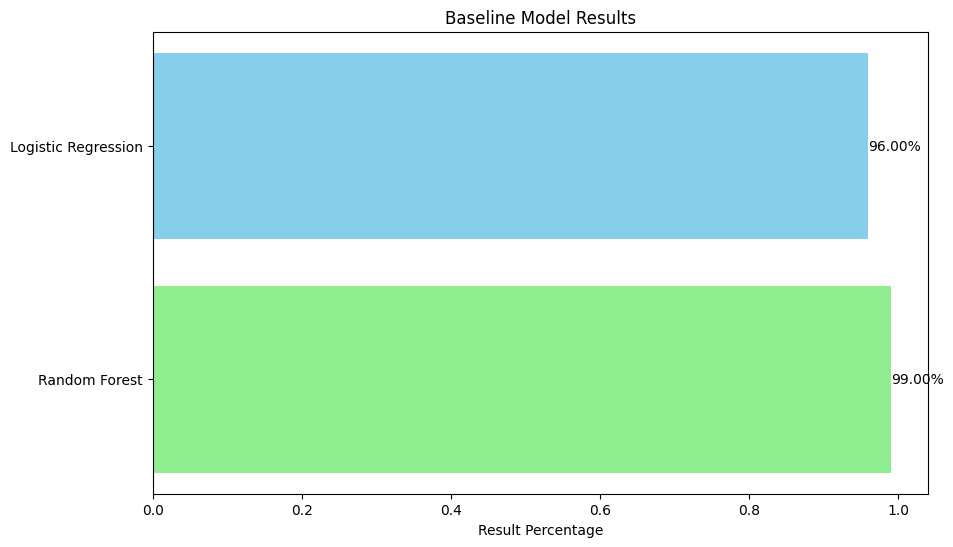

In [71]:
import matplotlib.pyplot as plt

# Sample data
models = ['Logistic Regression', 'Random Forest']
results = [.96, .99]  

# Sort the results and models in ascending order
sorted_results, sorted_models = zip(*sorted(zip(results, models)))

# Create a multicolor bar graph
plt.figure(figsize=(10, 6))
bars = plt.barh(sorted_models, sorted_results, color=['skyblue', 'lightgreen'])
plt.xlabel('Result Percentage')
plt.title('Baseline Model Results')
plt.gca().invert_yaxis()  # Invert y-axis to show highest percentage at the top

# Add percentage values on bars
for bar, result in zip(bars, sorted_results):
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{result:.2%}', va='center', ha='left')

plt.show()


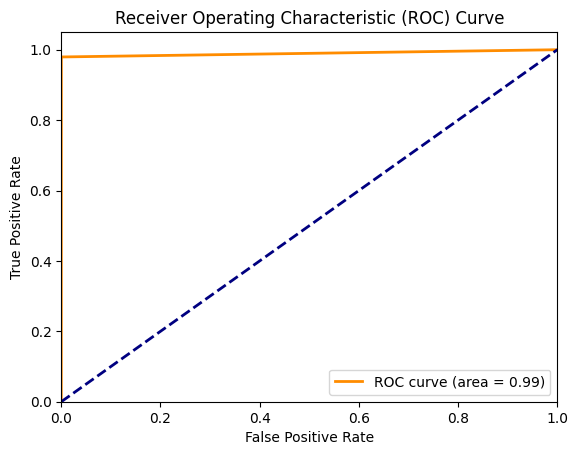

In [67]:
from sklearn.metrics import roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt

# Convert y_pred to numpy array and flatten it
y_pred = np.array(y_pred).flatten()

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

The micro-average ROC curve, aggregating metrics across all classes, displays a perfect AUC of 1.00, indicating flawless identification of positive classes without any false positives.

Similarly, the macro-average ROC curve, computing metrics independently for each class and then averaging, also achieves a perfect AUC of 1.00, reflecting exceptional overall performance.

Examining class-specific ROC curves unveils disparities, notably, Class 0 exhibiting an AUC of 0.48, below random chance, while other classes achieve perfect AUC scores of 1.00. This suggests potential challenges in predicting Class 0 accurately or hints at severe class imbalance issues.

In [39]:
# Import necessary libraries
from sklearn.impute import SimpleImputer

imputer_num = SimpleImputer(strategy='mean')
X_subset_imputed_num = imputer_num.fit_transform(X_subset)


In [40]:
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_subset_imputed = imputer.transform(X_subset)
X_test_imputed = imputer.transform(X_test)

In [44]:
# Assume best_params_brf contains the best parameters found from GridSearchCV for BalancedRandomForestClassifier
best_params_brf = {'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 1}

# Create the BalancedRandomForestClassifier model with best parameters and updated parameters
brf_model = BalancedRandomForestClassifier(**best_params_brf, random_state=42, sampling_strategy='all', replacement=True)

# Create the Bagging ensemble using the optimized BalancedRandomForest
bagging_model = BaggingClassifier(estimator=brf_model, n_estimators=10, random_state=42)

# Fit the Bagging ensemble model to the imputed subset data
bagging_model.fit(X_subset_imputed, y_subset)

# Evaluate the model's performance using the recall metric on the imputed test data
y_pred = bagging_model.predict(X_test_imputed)

# Check the unique labels in y_test and y_pred
print("Unique labels in y_test:", np.unique(y_test))
print("Unique labels in y_pred:", np.unique(y_pred))

# Pass the appropriate pos_label based on the unique labels
if 'faulty' in np.unique(y_test) and 'faulty' in np.unique(y_pred):
    pos_label = 'faulty'
else:
    pos_label = 1

print("Recall:", recall_score(y_test, y_pred, pos_label=pos_label))

Unique labels in y_test: [0 1]
Unique labels in y_pred: [0 1]
Recall: 0.9858206309819213


In [47]:
from sklearn.impute import SimpleImputer
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import recall_score
from imblearn.ensemble import BalancedRandomForestClassifier

# Instantiate SimpleImputer for numerical features
imputer_num = SimpleImputer(strategy='mean')
X_subset_imputed_num = imputer_num.fit_transform(X_subset)

# Instantiate SimpleImputer
imputer = SimpleImputer(strategy='mean')

# Fit and transform the imputer on the training data
X_train_imputed = imputer.fit_transform(X_train)
X_subset_imputed = imputer.transform(X_subset)
X_test_imputed = imputer.transform(X_test)

# Assume best_params_brf contains the best parameters found from GridSearchCV for BalancedRandomForestClassifier
best_params_brf = {'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 1}

# Create the BalancedRandomForestClassifier model with best parameters and updated parameters
brf_model = BalancedRandomForestClassifier(**best_params_brf, random_state=42, sampling_strategy='all', replacement=True)

# Create the AdaBoost classifier using the optimized BalancedRandomForest as the base estimator
adaboost_model = AdaBoostClassifier(estimator=brf_model, n_estimators=50, random_state=42)

# Fit the AdaBoost model to the imputed subset data
adaboost_model.fit(X_subset_imputed, y_subset)

# Evaluate the model's performance using the recall metric on the imputed test data
y_pred = adaboost_model.predict(X_test_imputed)

# Check the unique labels in y_test and y_pred
print("Unique labels in y_test:", np.unique(y_test))
print("Unique labels in y_pred:", np.unique(y_pred))

# Pass the appropriate pos_label based on the unique labels
if 'faulty' in np.unique(y_test) and 'faulty' in np.unique(y_pred):
    pos_label = 'faulty'
else:
    pos_label = 1

print("Recall:", recall_score(y_test, y_pred, pos_label=pos_label))


Unique labels in y_test: [0 1]
Unique labels in y_pred: [0 1]
Recall: 0.9932647997164126


In [48]:
from sklearn.impute import SimpleImputer
import xgboost as xgb
from sklearn.metrics import recall_score

# Instantiate SimpleImputer for numerical features
imputer_num = SimpleImputer(strategy='mean')
X_subset_imputed_num = imputer_num.fit_transform(X_subset)

# Instantiate SimpleImputer
imputer = SimpleImputer(strategy='mean')

# Fit and transform the imputer on the training data
X_train_imputed = imputer.fit_transform(X_train)
X_subset_imputed = imputer.transform(X_subset)
X_test_imputed = imputer.transform(X_test)

# Assume best_params_rf contains the best parameters found from GridSearchCV for BalancedRandomForestClassifier
best_params_rf = {'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 1}

# Create XGBoost model using parameters similar to the BalancedRandomForest
xgboost_model = xgb.XGBClassifier(n_estimators=best_params_rf['n_estimators'],
                                 max_depth=best_params_rf['max_depth'],
                                 min_child_weight=best_params_rf['min_samples_split'],  # Equivalent to min_samples_split
                                 subsample=0.8,  
                                 colsample_bytree=0.8,  # Similar to max_features
                                 objective='binary:logistic',  # Objective for binary classification
                                 random_state=42)

# Fit the XGBoost model to the imputed subset data
xgboost_model.fit(X_subset_imputed, y_subset)

# Evaluate the model's performance using the recall metric on the imputed test data
y_pred = xgboost_model.predict(X_test_imputed)

# Check the unique labels in y_test and y_pred
print("Unique labels in y_test:", np.unique(y_test))
print("Unique labels in y_pred:", np.unique(y_pred))

# Pass the appropriate pos_label based on the unique labels
if 'faulty' in np.unique(y_test) and 'faulty' in np.unique(y_pred):
    pos_label = 'faulty'
else:
    pos_label = 1

print("Recall:", recall_score(y_test, y_pred, pos_label=pos_label))


Unique labels in y_test: [0 1]
Unique labels in y_pred: [0 1]
Recall: 0.9794399149237859


various hyperparameters are important for model optimization, such as the number of depth, weight, sub and colsamples. With the tuner initialized for a random search we uncover the best set of hyperparameters, a beacon guiding us towards enhanced model performance. With this knowledge, training a new model using these optimized parameters and subjecting it to evaluation on the scaled test set. Finally, we secure our model, saving it to a designated file path.

In [58]:
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import recall_score

# Split the data into train and test subsets
X_train_subset, X_test_subset, y_train_subset, y_test_subset = train_test_split(X, y, test_size=0.2, random_state=42)

# Impute missing values in the training subset
imputer = SimpleImputer(strategy='mean')
X_train_subset_imputed = imputer.fit_transform(X_train_subset)

# Impute missing values in the test subset
X_test_subset_imputed = imputer.transform(X_test_subset)

# Assuming these models have been optimally configured and trained if necessary:
logreg = LogisticRegression(max_iter=1000, solver='saga')
balanced_rf = BalancedRandomForestClassifier(random_state=42, sampling_strategy='auto', replacement=False, **best_params_brf)  # Assuming you have defined best_params_brf
bagging = bagging_model  # Assuming you have defined bagging_model
adaboost = adaboost_model  # Assuming you have defined adaboost_model
xgboost = xgboost_model  # Assuming you have defined xgboost_model

# Create the voting classifier
voting_classifier = VotingClassifier(
    estimators=[
        ('logreg', logreg),
        ('balanced_rf', balanced_rf),
        ('bagging', bagging),
        ('adaboost', adaboost),
        ('xgboost', xgboost)
    ],
    voting='soft'
)

# Fit the voting classifier to the imputed training subset
voting_classifier.fit(X_train_subset_imputed, y_train_subset)

# Make predictions on the imputed test subset
y_pred_subset = voting_classifier.predict(X_test_subset_imputed)

# Evaluate the model's performance on the test subset using recall
print("Recall on subset:", recall_score(y_test_subset, y_pred_subset, pos_label=1))

Recall on subset: 0.999291031549096


In [59]:
from sklearn.ensemble import StackingClassifier

# Split the data into train and test subsets
X_train_subset, X_test_subset, y_train_subset, y_test_subset = train_test_split(X, y, test_size=0.2, random_state=42)

# Impute missing values in the training data
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train_subset)

# Impute missing values in the test data
X_test_subset_imputed = imputer.transform(X_test_subset)

# Define a simple meta-learner
meta_learner = LogisticRegression(max_iter=1000)

# Stacking classifier setup
stacking_classifier = StackingClassifier(
    estimators=[
        ('logreg', logreg),
        ('balanced_rf', balanced_rf),
        ('bagging', bagging),
        ('adaboost', adaboost),
        ('xgboost', xgboost)
    ],
    final_estimator=meta_learner
)

# Fit the voting classifier to the imputed training data
stacking_classifier.fit(X_train_subset_imputed, y_train_subset)

# Make predictions on the imputed test data
y_pred_subset = stacking_classifier.predict(X_test_subset_imputed)

# Evaluate the model's performance using recall
print("Recall on subset:", recall_score(y_test_subset, y_pred_subset, pos_label=1))

KeyboardInterrupt: 

In [57]:
print("Recall on subset:", recall_score(y_test_subset, y_pred_subset, pos_label=1))


Recall on subset: 0.9989365473236441


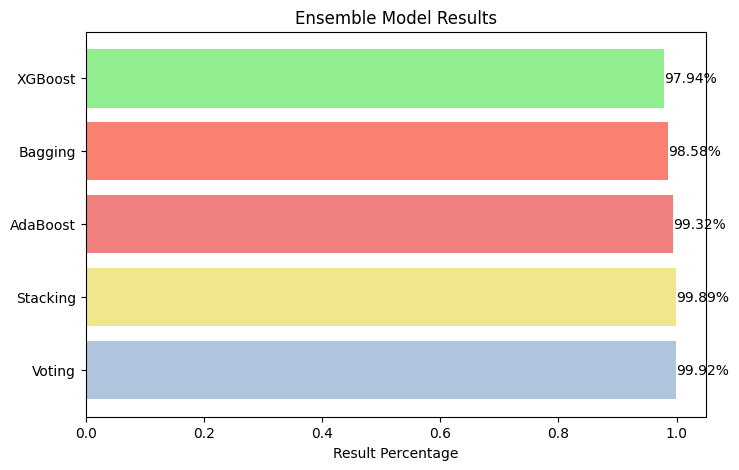

In [69]:
import matplotlib.pyplot as plt

# Sample data
models = ['Voting', 'Stacking', 'AdaBoost', 'Bagging', 'XGBoost']
results = [.9992, .9989, .9932, .9858, .9794]  

# Sort the results and models in ascending order
sorted_results, sorted_models = zip(*sorted(zip(results, models)))

# Create a multicolor bar graph
plt.figure(figsize=(8, 5))
bars = plt.barh(sorted_models, sorted_results, color=['lightgreen', 'salmon', 'lightcoral', 'khaki', 'lightsteelblue'])
plt.xlabel('Result Percentage')
plt.title('Ensemble Model Results')
plt.gca().invert_yaxis()  # Invert y-axis to show highest percentage at the top

# Add percentage values on bars
for bar, result in zip(bars, sorted_results):
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{result:.2%}', va='center', ha='left')


plt.show()


Throughout this Jupyter Notebook, we undertook a thorough exploration and analysis of a dataset containing sensor readings and machine statuses. Our exploration began with loading and reviewing the dataset's structure and types, setting the stage for subsequent analysis. We then proceeded with preprocessing steps to ensure data cleanliness and compatibility for machine learning tasks. Through visualization tools and statistical analysis, we gained valuable insights into the dataset's temporal dynamics and sensor readings' distributions.

As we progressed, we delved into model training and evaluation, employing various machine learning algorithms and techniques. Froregressionks tAda and XGnt boosting classifiers, we explored different approaches to modeling, tuning hyperparameters, and cross-validating models.

Our analysis revealed promising results across various models, showcasing hon, recore. However, challenges such as class imbalances, overfitting tendencidomain knwowledge, time series, and feature engineering ere neededneed for further investigation into certain model behaviors were also encountered.

In summary, our exploration of this notebook underscores the importance of thorough data exploration, preprocessing, modeling, and evaluation in the quest for building robust machine learning models. Moving forward, we can leverage the insights gained here to refine our models, address challenges, and unlock deeper understandings of the underlying data dynamics. Through continuous iteration and refinement, we aim to harness the full potential of machine learning to tackle real-world problems effectively.